In [71]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sts

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest

In [2]:
df = pd.read_csv('[5]EPL_data_after_EDA.csv', index_col=0, parse_dates=['Date'])
df.head()

,Date,Time,Location,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AR,AvgH,AvgD,AvgA,Elo_HomeTeam,Elo_AwayTeam,Temperature,Humidity,Wind Speed,Condition
0,2024-04-25,20:00,EGKK,Brighton,Man City,0,4,A,0,3,...,0,6.568,4.890,1.426,1748.398682,2038.480591,44.750000,78.125000,5.687500,Fair
1,2024-04-24,20:00,EGCC,Man United,Sheffield United,4,2,H,1,1,...,0,1.304,6.056,8.154,1793.209839,1551.766602,44.979167,62.333333,7.062500,Mostly Cloudy
2,2024-04-24,20:00,EGGP,Everton,Liverpool,2,0,H,1,0,...,0,7.048,4.910,1.410,1692.962402,1923.581787,45.833333,65.523810,7.595238,Partly Cloudy
3,2024-04-24,20:00,EGLC,Crystal Palace,Newcastle,2,0,H,0,0,...,0,2.742,3.620,2.410,1708.831055,1811.576782,45.979167,59.250000,7.604167,Fair
4,2024-04-24,19:45,EGBB,Wolves,Bournemouth,0,1,A,0,1,...,1,2.698,3.586,2.476,1711.067993,1695.033447,43.958333,69.208333,6.520833,Fair


### Гипотезы

При разведочном анализе данных было построено много визуализаций для наших данных. После визуализации появились следующие гипотезы, которые нужно проверить:

1. Команда, играющая дома, чаще побеждает
2. Команда, играющая дома, чаще бьет по воротам
4. Команда, играющая дома, имеет больше угловых ударов
5. Команда, имеющая больший Elo rating, чаще побеждает
6. Команды, играющие дома и в гостях нарушают правила одинаковое количество раз
7. Выигрывающая команда нарушает правила реже проигрывающей

## №1


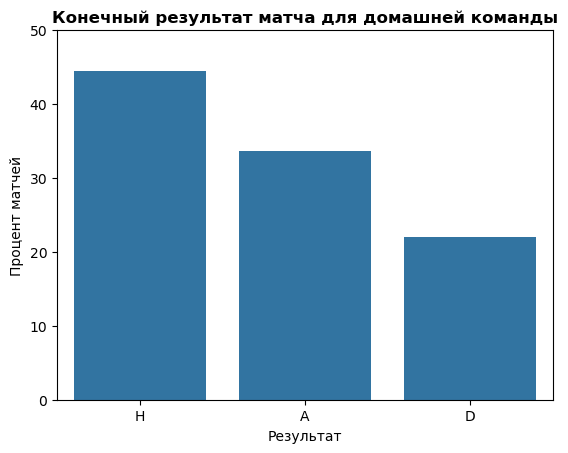

In [35]:
sns.countplot(data=df, x=df.FTR, order=df['FTR'].value_counts().index, stat='percent')

plt.xlabel('Результат')
plt.ylabel('Процент матчей')
plt.title('Конечный результат матча для домашней команды', weight='bold')
plt.ylim(0, 50);

Было замечено, что домашние команды чаще выигрывают свои матчи, чем гостевые. Попробуем проверить это с помощью статистики. 

$p_H$, $p_A$ - доли побед домашней и гостевой команд в матчах, где не было ничьей. Ничью предсказывать сложнее, для простоты реализации не будем учитывать матчи, в которых она была. Тогда случайная величина "победа команды" $X$ ~ $Be(p)$


$$H_0: p_H = 0.5$$

$$H_1: p_H > 0.5$$

Воспользуемся Z-тестом для пропорций. 

Предпосылки: наблюдений много, выбросов нет, наблюдения отчасти зависимы, так как это команды, которые играют в разных сезонах. Тем не менее, сезонов много, а команды ощутимо меняются каждые полгода (приходят новые игроки, меняется тактика, тренер и тд). Поэтому в качестве допущения посчитаем наблюдения независимыми.
Тогда можем использовать ЦПТ

Для начала определим, что у нас есть $N_H$ и $N_A$ - количества матчей с победой хозяев и гостей. Доли будут считаться от этих количеств. Тогда $p_H = \frac{N_H}{N_H + N_A}$, $p_A = 1 - p_H$

$$Z_{score} = \frac{p_H - 0.5}{\sqrt{\frac{p_H (1 - p_H)}{N_H + N_A}}}$$

In [196]:
N = len(df['FTR'][df['FTR'] != 'D'])
N_H = (df['FTR'][df['FTR'] != 'D'] == 'H').sum()

print(f"Всего наблюдений без ничьей {len(df['FTR'][df['FTR'] != 'D'])}")
print(f"Побед домашней команды {(df['FTR'][df['FTR'] != 'D'] == 'H').sum()}")

Всего наблюдений без ничьей 1689
Побед домашней команды 962


In [197]:
alpha = 0.05

z_score, p_value = proportions_ztest(count = N_H, nobs = N, value = 0.5, alternative = 'larger')

print(f'Z-score = {z_score:.3f}')
print(f'p-value = {p_value:.9f}')

Z-score = 5.774
p-value = 0.000000004


**Вывод:** нулевая гипотеза отвергается, домашняя команда действительно побеждает чаще гостевой

## №2

**Команда, играющая дома, чаще бьет по воротам**

Проверим нормальность распределения ударов по воротам

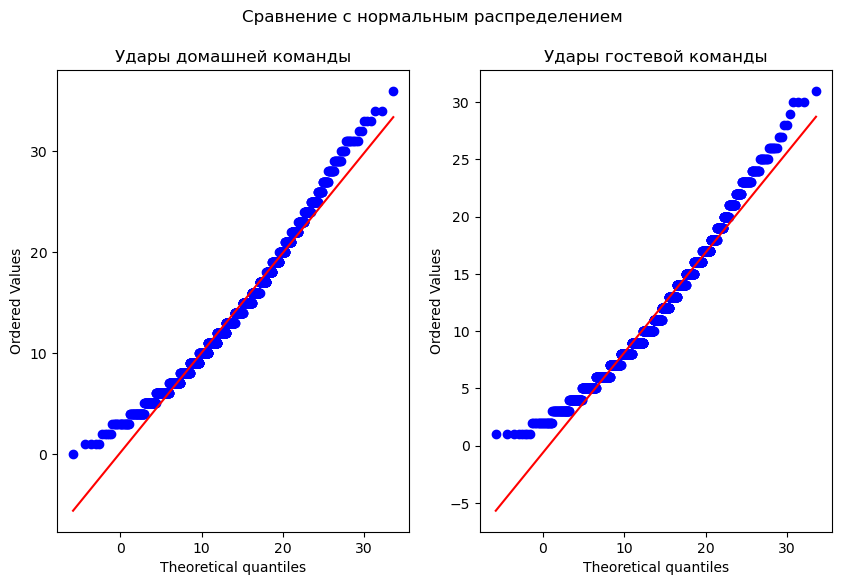

In [209]:
plt.figure (figsize = (10, 6))

plt.suptitle('Сравнение с нормальным распределением')

ax_1 = plt.subplot(1, 2, 1)
x = df.HS.values
sts.probplot(x, dist="norm", sparams=(x.mean(), x.std()), plot = ax_1)
ax_1.set_title('Удары домашней команды')

ax_2 = plt.subplot(1, 2, 2)
y = df.AS.values
sts.probplot(y, dist="norm", sparams=(x.mean(), x.std()), plot = ax_2)
ax_2.set_title('Удары гостевой команды');

Выборки не нормальные, хотя и похожи на них

Так как наблюдений достаточно много (>2000), воспользуемся ЦПТ и предположением о том, что выборки независимые. Выбросов нет.

Введем гипотезу о разности мат. ожиданий:

$$H_0: \mu_H - \mu_A = 0$$
$$H_1: \mu_H - \mu_A > 0$$

Будем пользоваться ЦПТ, наблюдений много. Поэтому распределение выборок не так важно
Так как разность средних распределена нормально, то:

$$Z_{score} = \frac{\hat{HS} - \hat{AS} - 0}{\sqrt{\frac{\sigma_{HS}^2}{N} + \frac{\sigma_{AS}^2}{N}}}$$

где $\hat{HS}$ и $\hat{AS}$ - средние ударов домашних и гостевых команд


In [72]:
z_score, p_value = ztest(df.HS, df.AS, alternative='larger')
print(f'Z-score = {z_score:.3f}')
print(f'p-value = {p_value:.9f}')

Z-score = 14.269
p-value = 0.000000000


**Вывод:** нулевая гипотеза отвергается, домашняя команда действительно бьет по воротам чаще гостевой

## №3

Команда, играющая дома, имеет больше угловых ударов

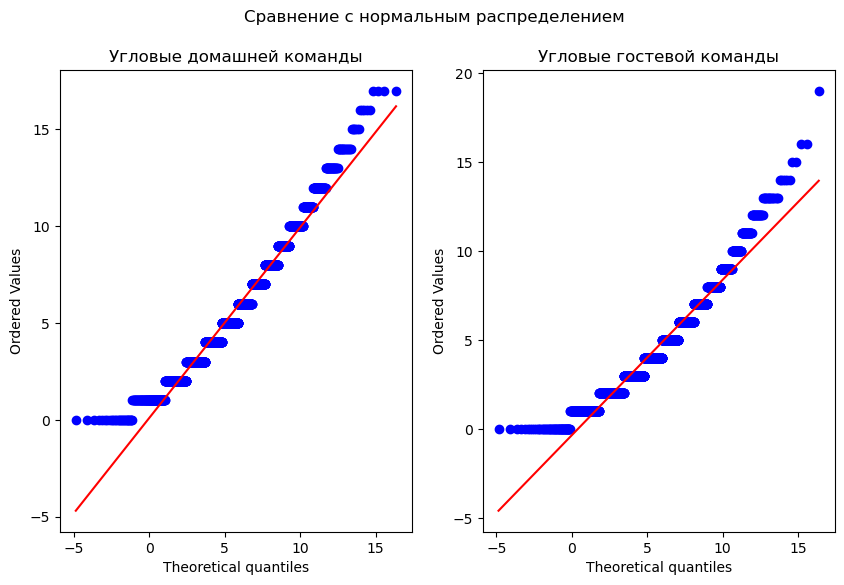

In [202]:
plt.figure (figsize = (10, 6))

plt.suptitle('Сравнение с нормальным распределением')

ax_1 = plt.subplot(1, 2, 1)
x = df.HC.values
sts.probplot(x, dist="norm", sparams=(x.mean(), x.std()), plot = ax_1)
ax_1.set_title('Угловые домашней команды')

ax_2 = plt.subplot(1, 2, 2)
y = df.AC.values
sts.probplot(y, dist="norm", sparams=(x.mean(), x.std()), plot = ax_2)
ax_2.set_title('Угловые гостевой команды');

Выборки не нормальные

Так как наблюдений достаточно много (>2000), воспользуемся ЦПТ и предположением о том, что выборки независимые. Выбросов нет.

Введем гипотезу о разности мат. ожиданий:

$$H_0: \mu_H - \mu_A = 0$$
$$H_1: \mu_H - \mu_A > 0$$

Будем пользоваться ЦПТ, наблюдений много. Поэтому распределение выборок не так важно
Так как разность средних распределена нормально, то:

$$Z_{score} = \frac{\hat{HC} - \hat{AC} - 0}{\sqrt{\frac{\sigma_{HC}^2}{N} + \frac{\sigma_{AC}^2}{N}}}$$

где $\hat{HC}$ и $\hat{AC}$ - средние количества угловых у домашних и гостевых команд


In [203]:
z_score, p_value = ztest(df.HC, df.AC, alternative='larger')
print(f'Z-score = {z_score:.3f}')
print(f'p-value = {p_value:.9f}')

Z-score = 11.955
p-value = 0.000000000


**Вывод:** нулевая гипотеза отвергается, домашняя команда действительно имеет больше угловых ударов

## №4

Elo-rating команд-победителей больше, чем у проигравших

Воспользуемся Z-тестом для разности мат. ожиданий. Снова не будем учитывать ничьи

Так как наблюдений достаточно много (1689), воспользуемся ЦПТ и предположением о том, что выборки независимые. Выбросов нет.

Введем гипотезу о разности мат. ожиданий:

$$H_0: \mu_{W_{Elo}} - \mu_{W_{Elo}} = 0$$
$$H_1: \mu_{W_{Elo}} - \mu_{L_{Elo}} > 0$$

Будем пользоваться ЦПТ, наблюдений много. Поэтому распределение выборок не так важно

Так как разность средних распределена нормально, то:

$$Z_{score} = \frac{\hat{W_{Elo}} - \hat{L_{Elo}} - 0}{\sqrt{\frac{\sigma_{W_{Elo}}^2}{N} + \frac{\sigma_{L_{Elo}}^2}{N}}}$$

где $\hat{W_{Elo}}$ и $\hat{L_{Elo}}$ - средний Elo-рейтинг победителей и проигравших


In [204]:
X = df.loc[:, ['FTR', 'Elo_HomeTeam', 'Elo_AwayTeam']][df.FTR != 'D']
X.head()

,FTR,Elo_HomeTeam,Elo_AwayTeam
0,A,1748.398682,2038.480591
1,H,1793.209839,1551.766602
2,H,1692.962402,1923.581787
3,H,1708.831055,1811.576782
4,A,1711.067993,1695.033447


In [205]:
# кодируем Elo для победителей и проигравших

X['W_Elo'] = (X['FTR'] == 'H') * (X['Elo_HomeTeam']) + (X['FTR'] == 'A') * (X['Elo_AwayTeam'])
X['L_Elo'] = (X['FTR'] == 'A') * (X['Elo_HomeTeam']) + (X['FTR'] == 'H') * (X['Elo_AwayTeam'])
X

,FTR,Elo_HomeTeam,Elo_AwayTeam,W_Elo,L_Elo
0,A,1748.398682,2038.480591,2038.480591,1748.398682
1,H,1793.209839,1551.766602,1793.209839,1551.766602
2,H,1692.962402,1923.581787,1692.962402,1923.581787
3,H,1708.831055,1811.576782,1708.831055,1811.576782
4,A,1711.067993,1695.033447,1695.033447,1711.067993
...,...,...,...,...,...
2159,A,1670.871338,1914.848877,1914.848877,1670.871338
2160,A,1567.101318,1837.004272,1837.004272,1567.101318
2161,A,1633.799683,1692.951660,1692.951660,1633.799683
2162,H,1673.780518,1576.490356,1673.780518,1576.490356


In [206]:
# Собственно тест

alpha = 0.05

z_score, p_value = ztest(X['W_Elo'], X['L_Elo'], alternative='larger')

print(f'Z-score = {z_score:.3f}')
print(f'p-value = {p_value:.9f}')

Z-score = 20.441
p-value = 0.000000000


**Вывод:** нулевая гипотеза отвергается, Elo-rating команд-победителей действительно больше, чем у проигравших

## №5

Команды, играющие дома и в гостях нарушают правила разное количество раз

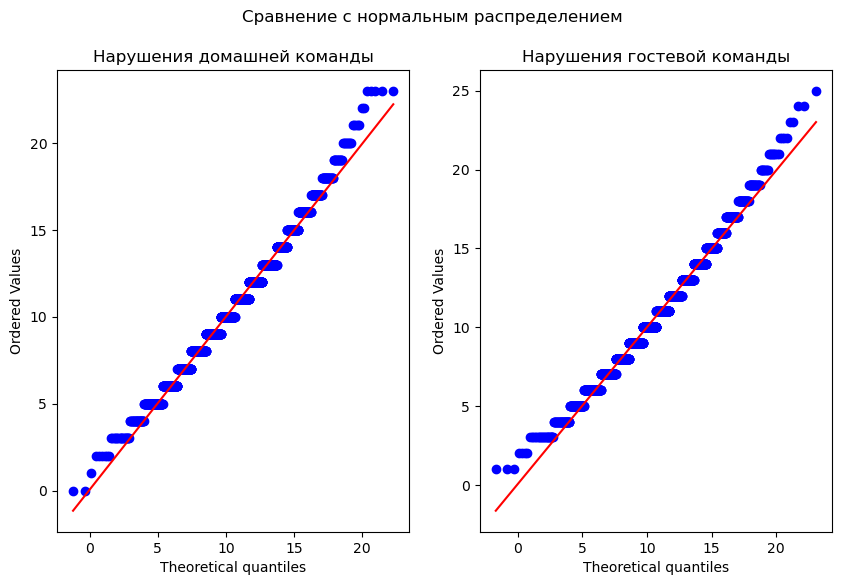

In [210]:
plt.figure (figsize = (10, 6))

plt.suptitle('Сравнение с нормальным распределением')

ax_1 = plt.subplot(1, 2, 1)
x = df.HF.values
sts.probplot(x, dist="norm", sparams=(x.mean(), x.std()), plot = ax_1)
ax_1.set_title('Нарушения домашней команды')

ax_2 = plt.subplot(1, 2, 2)
y = df.AF.values
sts.probplot(y, dist="norm", sparams=(y.mean(), y.std()), plot = ax_2)
ax_2.set_title('Нарушения гостевой команды');

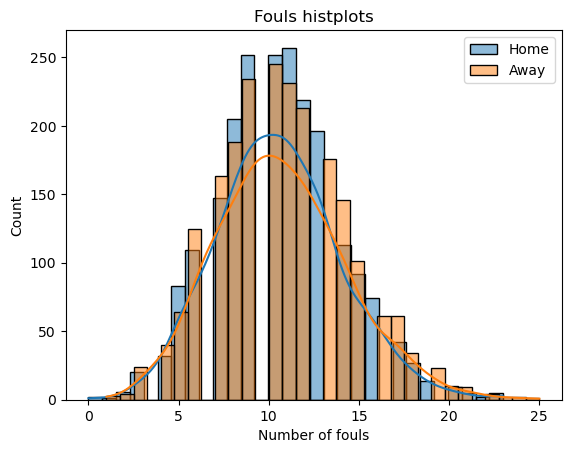

In [208]:
plt.title('Fouls histplots')
plt.xlabel('Number of fouls')

sns.histplot(df.HF, kde=True, label='Home')
sns.histplot(df.AF, kde=True, label='Away')

plt.legend();

Выборки похожи на нормальные, но мы и так ввели допущение, что элементы независимы. Поэтому все равно воспользуемся асимптотическим Z-тестом. Наблюдений много, выбросов нет. ЦПТ будет работать

Введем гипотезу о разности мат. ожиданий количества нарушений:

$$H_0: \mu_H - \mu_A = 0$$
$$H_1: \mu_H - \mu_A \not = 0$$

Будем пользоваться ЦПТ, наблюдений много. Поэтому распределение выборок не так важно

Так как разность средних распределена нормально, то:

$$Z_{score} = \frac{\hat{HF} - \hat{AF} - 0}{\sqrt{\frac{\sigma_{HF}^2}{N} + \frac{\sigma_{AF}^2}{N}}}$$

где $\hat{HF}$ и $\hat{AF}$ - средние количества нарушений у домашних и гостевых команд

In [136]:
z_score, p_value = ztest(df.HF, df.AF, alternative='two-sided')
print(f'Z-score = {z_score:.3f}')
print(f'p-value = {p_value:.9f}')

Z-score = -1.418
p-value = 0.156304708


__Вывод:__ нулевая гипотеза не отвергается, домашние и гостевые команды действительно фолят примерно одинаковое количество раз

## №6

Выигрывающая команда нарушает правила меньше, чем проигрывающая

Воспользуемся Z-тестом для разности мат. ожиданий. Снова не будем учитывать ничьи

Так как наблюдений достаточно много (1689), воспользуемся ЦПТ и предположением о том, что выборки независимые. Выбросов нет.

Введем гипотезу о разности мат. ожиданий:

$$H_0: \mu_{WF} - \mu_{LF} = 0$$
$$H_1: \mu_{WF} - \mu_{LF} < 0$$

Будем пользоваться ЦПТ, наблюдений много. Поэтому распределение выборок не так важно
Так как разность средних распределена нормально, то:

$$Z_{score} = \frac{\hat{WF} - \hat{LF} - 0}{\sqrt{\frac{\sigma_{WF}^2}{N} + \frac{\sigma_{LF}^2}{N}}}$$

где $\hat{WF}$ и $\hat{LF}$ - средние количества нарушений у победителей и проигравших


In [213]:
# вводим нарушения победителей и проигравших

xw = df.loc[:, ['FTR', 'HF', 'AF']][df.FTR != 'D']

xw['WF'] = (xw['FTR'] == 'H') * (xw['HF']) + (xw['FTR'] == 'A') * (xw['AF'])
xw['LF'] = (xw['FTR'] == 'A') * (xw['HF']) + (xw['FTR'] == 'H') * (xw['AF'])
xw

,FTR,HF,AF,WF,LF
0,A,10,3,3,10
1,H,7,9,7,9
2,H,6,13,6,13
3,H,10,15,10,15
4,A,10,17,17,10
...,...,...,...,...,...
2159,A,11,12,12,11
2160,A,9,8,8,9
2161,A,9,11,11,9
2162,H,11,9,11,9


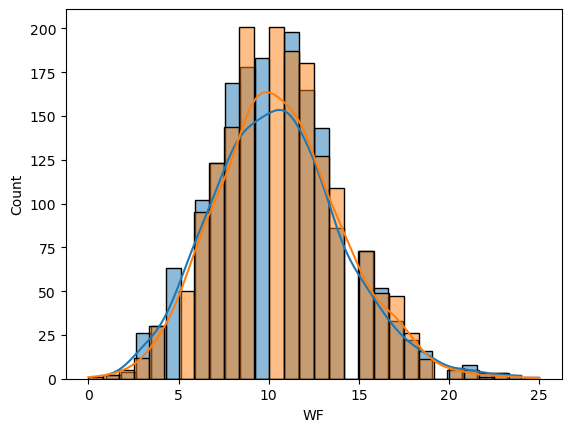

In [214]:
sns.histplot(xw['WF'], kde=True)
sns.histplot(xw['LF'], kde=True);

Распределения выглядят похожими, посмотрим, действительно ли победители фолят меньше

In [215]:
# Собственно тест

alpha = 0.05

z_score, p_value = ztest(xw['WF'], xw['LF'], value=0, alternative='smaller')

print(f'Z-score = {z_score:.3f}')
print(f'p-value = {p_value:.9f}')

Z-score = -1.308
p-value = 0.095358907


Вывод: гипотеза не отвергается на уровне значимости 5%, но может быть отвергнута на уровне значимости 10%. Так как мы приняли $\alpha = 0.05$, нулевая гипотеза **не отвергается**. Победители и проигравшие фолят примерно одинаковое количество раз